In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"


from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


Using plaidml.keras.backend backend.


In [2]:
train_data_dir = 'Downloads/dogs-vs-cats/train/train/'
test_data_dir = 'Downloads/dogs-vs-cats/test1/test1/'

In [3]:
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [4]:
img_width, img_height = 32,32
img_size=(img_width, img_height)
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [5]:
import pandas as pd
categories = {}
for file in os.listdir(train_data_dir+'dog'):
    categories[train_data_dir+'dog/'+file] = 1
for file in os.listdir(train_data_dir+'cat'):
    categories[train_data_dir+'cat/'+file] = 0
df=pd.DataFrame.from_dict(categories,orient = 'index')


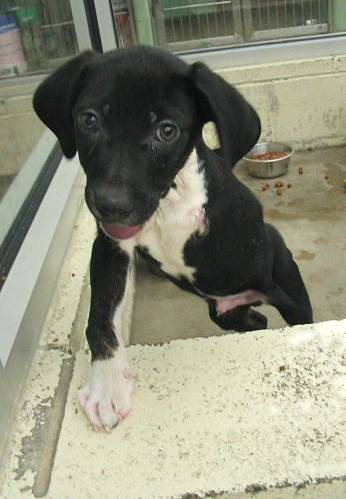

In [6]:
import random
load_img(train_data_dir+'dog/'+random.choice(os.listdir(train_data_dir+'dog')))

In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

INFO:plaidml:Opening device "opencl_nvidia_geforce_gtx_750_ti.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [9]:
df = df.reset_index()
df.columns = ['filename','category']

In [10]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [11]:
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [12]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='category',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.


In [14]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    x_col='filename',
    y_col='category',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 images belonging to 2 classes.


In [17]:
FAST_RUN = False
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
1333/1333 [==============================] - 176s 132ms/step - loss: 0.6064 - acc: 0.6815 - val_loss: 0.6329 - val_acc: 0.6617
Epoch 2/50
1333/1333 [==============================] - 179s 134ms/step - loss: 0.5952 - acc: 0.6893 - val_loss: 0.5324 - val_acc: 0.7306
Epoch 3/50
1333/1333 [==============================] - 173s 130ms/step - loss: 0.5795 - acc: 0.7024 - val_loss: 0.7921 - val_acc: 0.5836
Epoch 4/50
1333/1333 [==============================] - 179s 134ms/step - loss: 0.5661 - acc: 0.7134 - val_loss: 0.5329 - val_acc: 0.7270

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
1333/1333 [==============================] - 186s 139ms/step - loss: 0.5413 - acc: 0.7299 - val_loss: 0.4714 - val_acc: 0.7721
Epoch 6/50
1333/1333 [==============================] - 188s 141ms/step - loss: 0.5276 - acc: 0.7383 - val_loss: 0.4737 - val_acc: 0.7749
Epoch 7/50
1333/1333 [==============================] - 175s 131ms/step - loss: 0.5229 - ac

In [18]:
model.save_weights("model.h5")

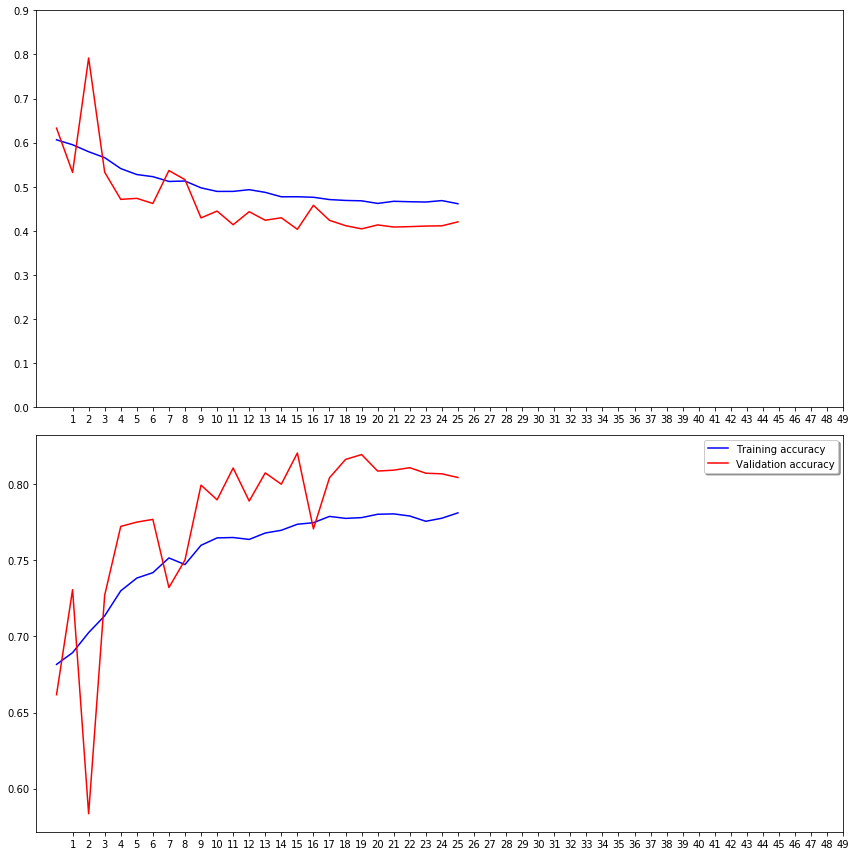

In [21]:

import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()



In [34]:
test_df = []
for file in os.listdir(test_data_dir):
    test_df.append(test_data_dir+file)
test_df=pd.DataFrame(test_df)
test_df.columns = ['filename']

In [35]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 images.


In [36]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [37]:
test_df['category'] = np.argmax(predict, axis=-1)

In [38]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

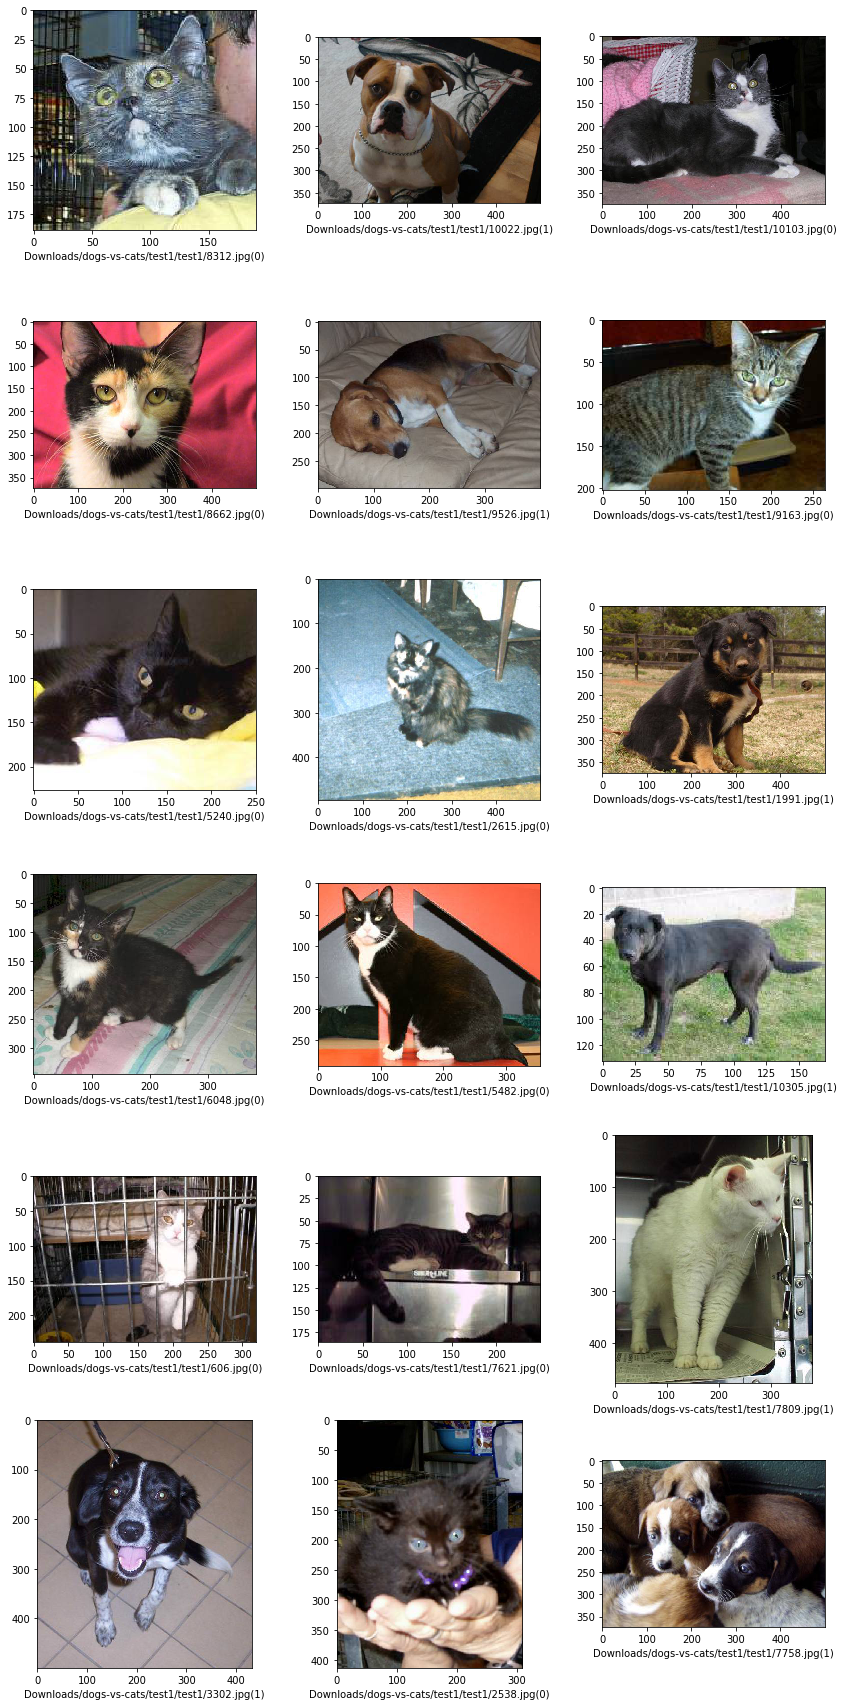

In [63]:
sample_test = test_df.sample(18)
sample_test.head()
plt.figure(figsize=(12, 24))
i = 0
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(filename)
    plt.subplot(6, 3, i+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
    i += 1
plt.tight_layout()
plt.show()

In [52]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
model_resnet = ResNet50(weights='imagenet')


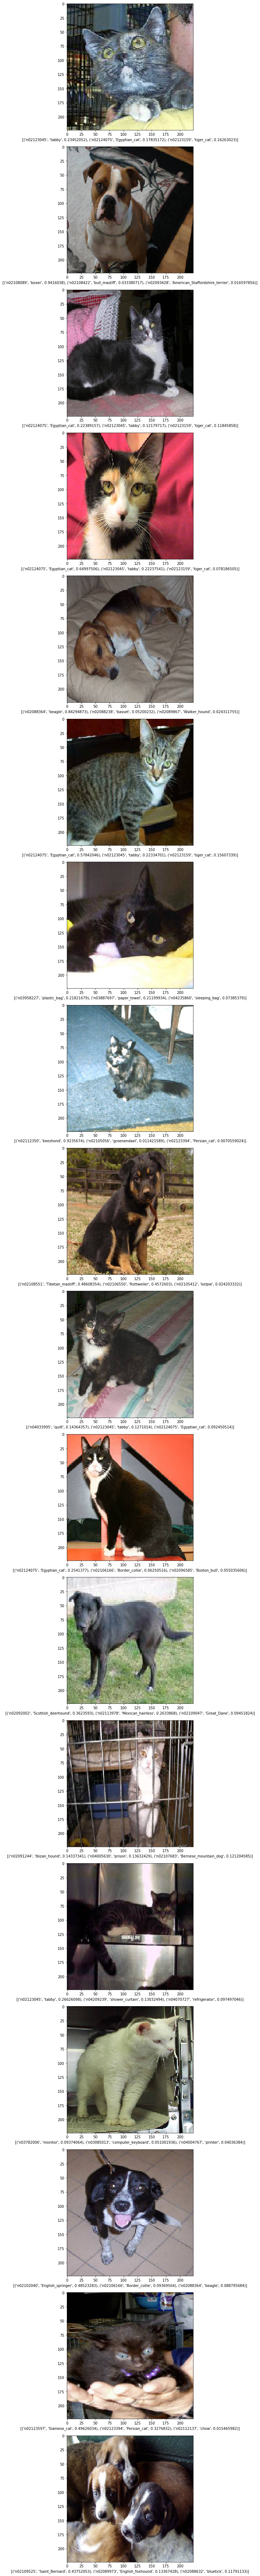

In [64]:
plt.figure(figsize=(24,100))
i = 0
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(filename,target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  
    preds = model_resnet.predict(x)
    plt.subplot(18,1, i+1)
    plt.imshow(img)
    plt.xlabel(str(decode_predictions(preds, top=3)[0]) )
    i += 1
plt.tight_layout()
plt.show()